In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install catboost    #CATBOOST VERSION 1.0.4

In [ ]:
!pip install -U lightgbm    #LIGHTGBM  VERSION 3.3.2

In [ ]:
!pip install -U xgboost   #XGBOOST 1.5.2

IMPORTING LIBRARIES

In [ ]:
import numpy as np
import pandas as pd
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

IMPORTING DATASET  (exact same data from competition website)

In [ ]:
train = pd.read_csv("/content/drive/MyDrive/UmojaData/train.csv")
policy = pd.read_csv("/content/drive/MyDrive/UmojaData/policies.csv")
test = pd.read_csv("/content/drive/MyDrive/UmojaData/test.csv")
sub = pd.read_csv("/content/drive/MyDrive/UmojaData/SampleSubmission.csv")

In [ ]:
policy['class_of_business'].mode()  #Filling Missing Values in Policy data with mode.

0    cob00031
dtype: object

In [ ]:
policy['class_of_business'] = policy['class_of_business'].fillna('cob00031')

Feature Engineering on Policy data.
- Group policy data by "policy number" and aggregating "max", "min","mean" and "count" for each group.
- Label Encode the categorical variables of the resulting data
- Merge with training and test data on "policy number"

In [ ]:
#Find the number of days between  policy["to_date"] and policy['from_date']
policy['diff_days'] = (pd.to_datetime(policy["to_date"]) - pd.to_datetime(policy['from_date'])).dt.days   


In [ ]:
pols = policy.groupby('policy_number').agg(
             prd_min = ('product_code', 'min'),
             prd_max = ('product_code', 'max'),
             prd_count = ('product_code', 'count'),
             ag_min = ('agent', 'min'),
             diff_days_min = ("diff_days", "min"),
             diff_days_max = ("diff_days", "max"),
             diff_days_mean = ("diff_days", "mean"),
             ag_max = ('agent', 'max'),
             class_min = ('class_of_business', 'min'),
             class_max = ('class_of_business', 'max'),).reset_index()

In [ ]:
pols.head()

,policy_number,prd_min,prd_max,prd_count,ag_min,diff_days_min,diff_days_max,diff_days_mean,ag_max,class_min,class_max
0,pol000005333,prod00002,prod00002,6,ag00005,79,365,215.333333,ag00006,cob00004,cob00004
1,pol000005334,prod00002,prod00002,27,ag00006,30,182,118.407407,ag00006,cob00001,cob00006
2,pol000005335,prod00002,prod00002,20,ag00007,41,122,112.800000,ag00007,cob00001,cob00004
3,pol000005336,prod00002,prod00002,90,ag00003,29,365,140.322222,ag00003,cob00001,cob00006
4,pol000005337,prod00002,prod00002,15,ag00005,120,121,120.600000,ag00005,cob00001,cob00004


In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
policy_cat = ["prd_max","ag_min", "prd_min","ag_max","class_min","class_max"]

In [ ]:
for col in policy_cat:
  lr = LabelEncoder()
  pols[col] = lr.fit_transform(pols[col])

In [ ]:
pols.head()

,policy_number,prd_min,prd_max,prd_count,ag_min,diff_days_min,diff_days_max,diff_days_mean,ag_max,class_min,class_max
0,pol000005333,1,1,6,4,79,365,215.333333,5,3,2
1,pol000005334,1,1,27,5,30,182,118.407407,5,0,4
2,pol000005335,1,1,20,6,41,122,112.800000,6,0,2
3,pol000005336,1,1,90,2,29,365,140.322222,2,0,4
4,pol000005337,1,1,15,4,120,121,120.600000,4,0,2


Feature Engineering on Train and Test data.
- Group data by "policy_number" and "product number" and extract aggregate features (mean, sum, count etc)
- map categorical variables to thier frequency of occurence.
- Extract date and time feature from "loss date"

In [ ]:
data = pd.concat([train, test]).reset_index()

In [ ]:
data['policy_insured_mean'] = data.groupby(['policy_number'])['sum_insured'].transform('mean')
data['policy_insured_max'] = data.groupby(['policy_number'])['sum_insured'].transform('max')
data['policy_insured_count'] = data.groupby(['policy_number'])['sum_insured'].transform('count')
data['policy_insured_sum'] = data.groupby(['policy_number'])['sum_insured'].transform('sum')


data['product_sum'] = data.groupby(['policy_number'])['product'].transform('count')
data['product_nunique'] = data.groupby(['policy_number'])['product'].transform('nunique')

In [ ]:
cat = ['claim_number','product', 'policy_number', 'agent', 'class_of_business', 'risk_type','client_type', 'renewal_frequency', 'primary_cause', 'secondary_cause',
       'branch']
for i in cat:
    data[i+'_freq'] = data[i].map(data[i].value_counts())

In [ ]:
data['loss_date'] = pd.to_datetime(data['loss_date'])

In [ ]:
data['loss_year'] = data['loss_date'].dt.year
data['loss_month'] = data['loss_date'].dt.month
data['loss_day'] = data['loss_date'].dt.day

Merge training (and test) data with policy data

In [ ]:
data = data.merge(pols, how='left', on='policy_number')

In [ ]:
for i in cat:
  le = LabelEncoder()
  data[i] = le.fit_transform(data[i])

Split Combined data into train and test

In [ ]:
train_df  = data[~data['target'].isna()].reset_index(drop=True)
test_df = data[data['target'].isna()].reset_index(drop=True)

## Modeling.

In [ ]:
X = train_df.drop(columns=['claim_id','claim_number', 'index', 'loss_date', 'target','policy_number'])
y = train_df['target']
X_test = test_df.drop(columns=['claim_id','claim_number', 'index', 'loss_date', 'target','policy_number'])

In [ ]:
X.head()

,sum_insured,product,agent,class_of_business,risk_type,client_type,renewal_frequency,primary_cause,secondary_cause,branch,...,prd_min,prd_max,prd_count,ag_min,diff_days_min,diff_days_max,diff_days_mean,ag_max,class_min,class_max
0,300000.0,26,4,30,5,2,0,6,20,5,...,26.0,26.0,8.0,31.0,119.0,122.0,120.875000,31.0,27.0,25.0
1,16000.0,4,7,9,31,2,0,6,21,1,...,4.0,4.0,2.0,10.0,122.0,122.0,122.000000,10.0,7.0,25.0
2,3000.0,28,1,9,25,2,0,6,22,1,...,28.0,28.0,2.0,47.0,121.0,121.0,121.000000,47.0,27.0,25.0
3,6000.0,4,1,8,31,2,0,6,19,0,...,4.0,4.0,6.0,18.0,119.0,130.0,122.666667,18.0,7.0,25.0
4,26850.0,14,7,32,22,0,0,6,19,0,...,14.0,14.0,11.0,59.0,93.0,122.0,117.090909,59.0,29.0,27.0


In [ ]:
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold

Transform target variable 

- Log transform the target variable (cuz it's very skewed) using `np.log1p()` but remember to reverse the transformation using `np.expm1()`

[more details](https://scikit-learn.org/stable/auto_examples/compose/plot_transformed_target.html)

[more details](https://www.kaggle.com/product-feedback/164183)


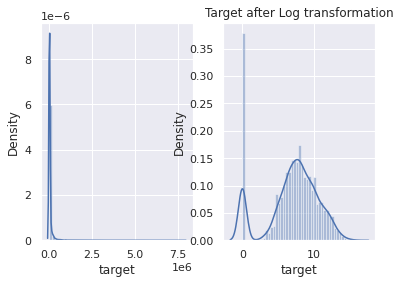

In [ ]:
sns.set()
y = train_df["target"]
y_transformed = pd.Series(np.log1p(y))

fig, ax = plt.subplots(1, 2)
sns.distplot(y, ax=ax[0])
plt.title("Target after Log transformation")
# ax[0].axvline(y_transformed)
sns.distplot(y_transformed, ax=ax[1])
plt.show()

In [ ]:
fold_pred=[]
oof_pred = []

params = {'colsample_bytree': 0.384606276881856,
 'learning_rate': 0.23251453473545997,
 'max_depth': 7,
 'subsample': 0.3530887571489526}




fold= KFold(n_splits=5)#15#5#10
i=1
for train_index, test_index in fold.split(X,y):     
  
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = np.log1p(y.iloc[train_index]), y.iloc[test_index]

    model = LGBMRegressor(**params, objective = "mae")
    model.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test, y_test)], early_stopping_rounds=300, verbose = False)#erly100

    preds= model.predict(X_test)
    print("err: ",(mean_absolute_error(y_test,np.expm1(preds))))  #Reverse transformation
    oof_pred.append(mean_absolute_error(y_test,np.expm1(preds)))
    p2 = model.predict(test_df[X.columns])
    fold_pred.append(np.expm1(p2))
    

print(np.mean(oof_pred))

err:  33900.17930738362
err:  37267.10023098928
err:  32324.45112652706
err:  27729.001944863216
err:  39939.52862143089
34232.05224623882


## Hyperparameter Tuning using Optuna. 

In [ ]:
def objective(trial):
    fold_pred=[]
    oof_pred = []


    param = {}
    param['objective'] = "mae"

    param["learning_rate"] = trial.suggest_float("learning_rate", 1e-2, 0.25, log=True)
#     param['reg_lambda'] = trial.suggest_loguniform("reg_lambda", 1e-8, 100.0)
#     param['reg_alpha'] = trial.suggest_loguniform("reg_alpha", 1e-8, 100.0)
    param['subsample'] = trial.suggest_float("subsample", 0.1, 1.0)
    param['colsample_bytree'] = trial.suggest_float("colsample_bytree", 0.1, 1.0)
    param['max_depth'] = trial.suggest_int("max_depth", 5, 20)
    # param['scale_pos_weight'] = trial.suggest_int('scale_pos_weight', 3, 10)




    fold=KFold(n_splits=3)#15#5#10
    i=1
    for train_index, test_index in fold.split(X,y):
        
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = np.log1p(y.iloc[train_index]), y.iloc[test_index]
        # m2 = CatBoostRegressor(**param)
        m2 = LGBMRegressor(**param)

        m2.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test, y_test)], early_stopping_rounds=500, verbose = False)#erly100
        preds=m2.predict(X_test)
        oof_pred.append(mean_absolute_error(y_test,np.expm1(preds)))

    

    return np.mean(oof_pred)


In [ ]:
!pip install optuna

In [ ]:
import optuna

Find best params

In [ ]:
# study = optuna.create_study(direction="minimize")
# study.optimize(objective, n_trials=100)

In [ ]:
# print("Number of finished trials: {}".format(len(study.trials)))

# print("Best trial:")
# trial = study.best_trial

# print("  Value: {}".format(trial.value))

# print("  Params: ")
# for key, value in trial.params.items():
#     print("    {}: {}".format(key, value))

Number of finished trials: 100
Best trial:
  Value: 33758.99131957881
  Params: 
    learning_rate: 0.23251453473545997
    subsample: 0.3530887571489526
    colsample_bytree: 0.384606276881856
    max_depth: 7


In [ ]:
# trial.params   #best params

{'colsample_bytree': 0.384606276881856,
 'learning_rate': 0.23251453473545997,
 'max_depth': 7,
 'subsample': 0.3530887571489526}

Text(0.5, 1.0, 'CatboostClassifier features importance (top 50):')

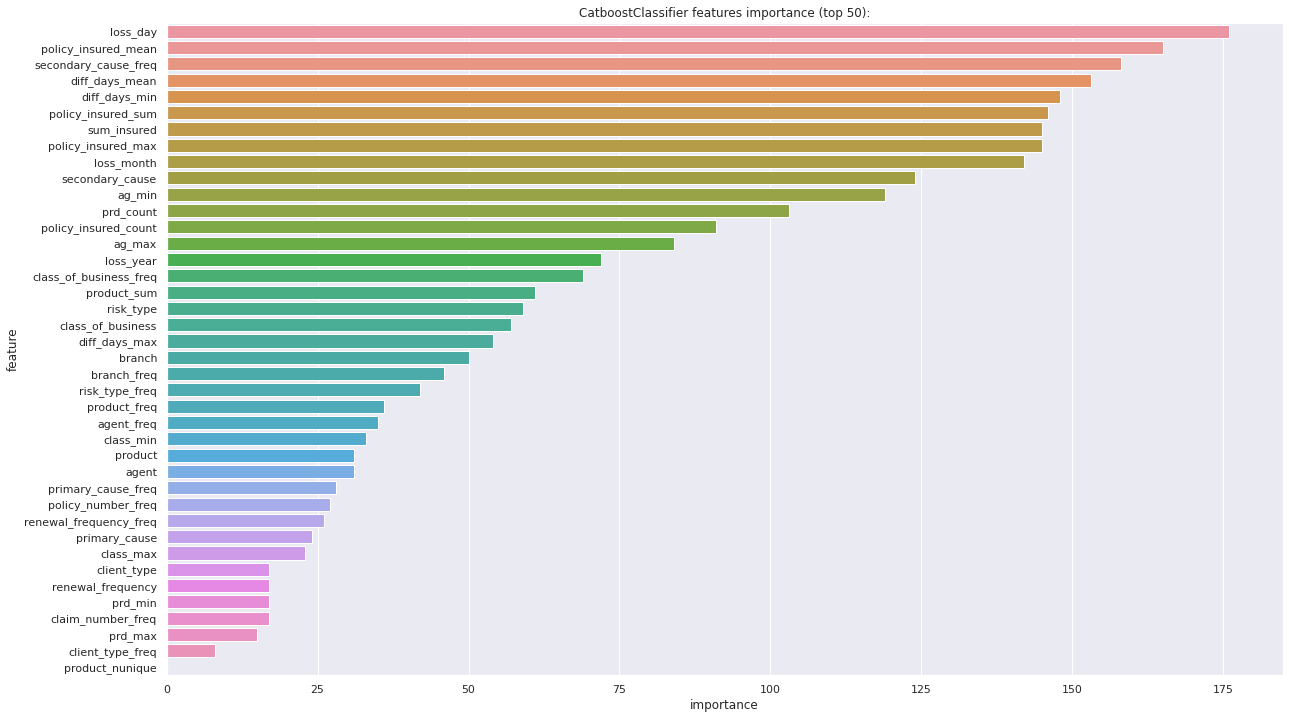

In [ ]:
# # 0.7831404345536787
feature_importance_df = pd.DataFrame(model.feature_importances_, columns=['importance'])
feature_importance_df['feature'] = X.columns

plt.figure(figsize=(20, 12));
sns.barplot(x="importance", y="feature", data=feature_importance_df.sort_values(by = ['importance'], ascending = False).head(60))
plt.title('CatboostClassifier features importance (top 50):')

## Submission

In [ ]:
sub['target'] =  np.mean(fold_pred, axis = 0)

In [ ]:
sub.head()

,claim_id,target
0,ID_4RO0KZI9BBW2,154964.276126
1,ID_GTE9ZUJ9GZ97,40191.625992
2,ID_RUVIYRKWZ4RG,2123.975472
3,ID_J81X8SWU6JYN,625.087877
4,ID_94NM3JJAWWOQ,9846.816691


In [ ]:
sub.to_csv('Submission.csv', index=False)